In [1]:
#TODO: add text and explanation to this notebook

In [2]:
import IPython

%matplotlib inline
import matplotlib.pyplot as plt
import torchaudio
import torch

import os,sys,inspect
sys.path.insert(0, "..")

from src.data import podcast
from src.dataprocessing import transforms as T
from src.utils import hparams

pre_path = '../../'

In [3]:
path = "MelNet-SpeechGeneration/models/params/dummymodel_podcast.yml"
hp = hparams.HParams.from_yaml(pre_path+path)

In [4]:
podcast = podcast.PODCAST(root='../'+hp.data.path, 
                          audio_folder=hp.data.audio_folder, 
                          text_file=hp.data.text_file)
dataloader_podcast = torch.utils.data.DataLoader(podcast)
dataiter = iter(dataloader_podcast)

In [5]:
waveform1, sample_rate1, utterance1, speaker_id1, chapter_id1, utterance_id1 = dataiter.next()
waveform2, sample_rate2, utterance2, speaker_id2, chapter_id2, utterance_id2 = dataiter.next()

In [6]:
# Move to GPU device if we can
waveform1 = waveform1.to(hp.training.device)
waveform2 = waveform2.to(hp.training.device)

## Wave to Spectrogram and Spectrogram to Wave

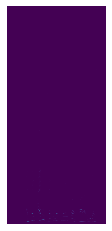

In [7]:
# Preparation and Transformation
spectrogram = T.wave_to_spectrogram(waveform1, hp)
T.plot_spectrogram(spectrogram, hp)

Waveform 0, shape: torch.Size([1, 89061])
Waveform 0, Sample rate: 22050


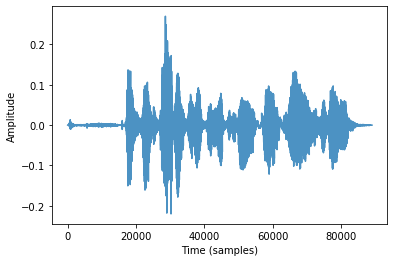

In [8]:
# Original
T.plot_wave(waveform1, hp)

Waveform 0, shape: torch.Size([1, 88832])
Waveform 0, Sample rate: 22050


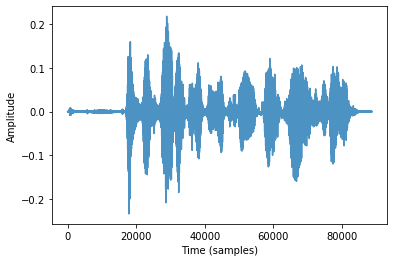

In [9]:
# Reconstructed
wave_rec = T.spectrogram_to_wave(spectrogram, hp, n_iter=32)
T.plot_wave(wave_rec, hp)

In [10]:
# difference between waves
print(waveform1.flatten().shape, wave_rec.flatten().shape)
print(torch.sum(torch.abs(wave_rec-waveform1.flatten()[:88832])))
print(torch.sum(torch.abs(wave_rec-waveform1.flatten()[:88832]))/torch.sum(torch.abs(waveform1.flatten()[:88832])))

torch.Size([89061]) torch.Size([88832])
tensor(1908.8564, device='cuda:0')
tensor(1.3518, device='cuda:0')


In [11]:
print("Original:")
IPython.display.Audio(data=waveform1.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Original:


In [12]:
print("Reconstructed:")
IPython.display.Audio(data=wave_rec.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Reconstructed:


In [13]:
print("Wave:        ", waveform1.shape, " Shape: [B, 1, L]")
print("Spectrogram: ", spectrogram.shape, " Shape: [B, FREQ, FRAMES]")
print("Wave_rec:    ", wave_rec.shape, " Shape: [B, 1, L']")

Wave:         torch.Size([1, 1, 89061])  Shape: [B, 1, L]
Spectrogram:  torch.Size([1, 769, 348])  Shape: [B, FREQ, FRAMES]
Wave_rec:     torch.Size([1, 1, 88832])  Shape: [B, 1, L']


## Spectrogram to Spectrogram dB and Spectrogram dB to Spectrogram

In [14]:
# Preparation
spectrogram = T.wave_to_spectrogram(waveform1, hp)

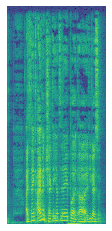

In [15]:
# Transformation
spectrogram_db = T.amplitude_to_db(spectrogram, hp)
T.plot_spectrogram(spectrogram_db, hp)

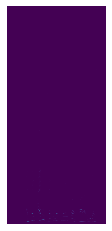

In [16]:
# Original
T.plot_spectrogram(spectrogram, hp)

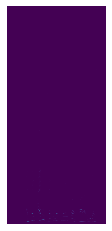

In [17]:
# Reconstructed
spectrogram_rec_from_db = T.db_to_amplitude(spectrogram_db, hp)
T.plot_spectrogram(spectrogram_rec_from_db, hp)

In [18]:
# difference between spectrograms
print(torch.sum(torch.abs(spectrogram_rec_from_db-spectrogram)))
print(torch.sum(torch.abs(spectrogram_rec_from_db-spectrogram))/torch.sum(torch.abs(spectrogram)))

tensor(0.0201, device='cuda:0')
tensor(1.7783e-07, device='cuda:0')


In [19]:
print("Spectrogram:             ", spectrogram.shape, " Shape: [B, FREQ, FRAMES]")
print("Spectrogram_db:          ", spectrogram_db.shape, " Shape: [B, FREQ, FRAMES]")
print("Spectrogram_rec_from_db: ", spectrogram_rec_from_db.shape, " Shape: [B, FREQ, FRAMES]")

Spectrogram:              torch.Size([1, 769, 348])  Shape: [B, FREQ, FRAMES]
Spectrogram_db:           torch.Size([1, 769, 348])  Shape: [B, FREQ, FRAMES]
Spectrogram_rec_from_db:  torch.Size([1, 769, 348])  Shape: [B, FREQ, FRAMES]


## Spectrogram to MelSpectrogram and MelSpectrogram to Spectrogram

In [20]:
# Preparation
spectrogram = T.wave_to_spectrogram(waveform1, hp)

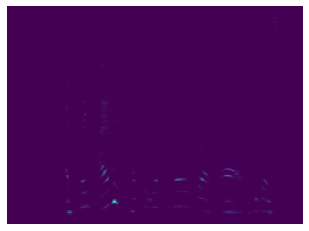

In [21]:
# Transformation
melspectrogram = T.spectrogram_to_melspectrogram(spectrogram, hp)
T.plot_melspectrogram(melspectrogram, hp)

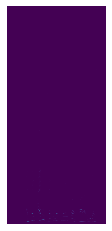

In [22]:
# Original
T.plot_spectrogram(spectrogram, hp)

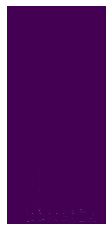

In [23]:
# Reconstructed
spectrogram_rec_from_mel = T.melspectrogram_to_spectrogram(melspectrogram, hp, n_iter=10000)
T.plot_spectrogram(spectrogram_rec_from_mel, hp)

In [24]:
# difference between spectrograms
print(torch.sum(torch.abs(spectrogram_rec_from_mel-spectrogram)))
print(torch.sum(torch.abs(spectrogram_rec_from_mel-spectrogram))/torch.sum(torch.abs(spectrogram)))

tensor(10069.6455, device='cuda:0')
tensor(0.0893, device='cuda:0')


In [25]:
print("Spectrogram:              ", spectrogram.shape, " Shape: [B, FREQ, FRAMES]")
print("Melspectrogram:           ", melspectrogram.shape, " Shape: [B, N_MELS, FRAMES]")
print("Spectrogram_rec_from_mel: ", spectrogram_rec_from_mel.shape, " Shape: [B, FREQ, FRAMES]")

Spectrogram:               torch.Size([1, 769, 348])  Shape: [B, FREQ, FRAMES]
Melspectrogram:            torch.Size([1, 256, 348])  Shape: [B, N_MELS, FRAMES]
Spectrogram_rec_from_mel:  torch.Size([1, 769, 348])  Shape: [B, FREQ, FRAMES]


## MelSpectrogram to MelSpectrogram dB and MelSpectrogram dB to MelSpectrogram

In [26]:
# Preparation
melspectrogram = T.wave_to_melspectrogram(waveform1, hp)

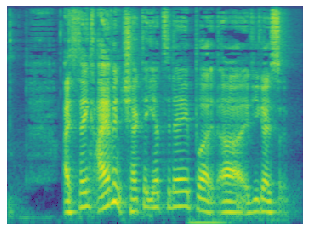

In [27]:
# Transformation
melspectrogram_db = T.amplitude_to_db(melspectrogram, hp)
T.plot_melspectrogram(melspectrogram_db, hp)

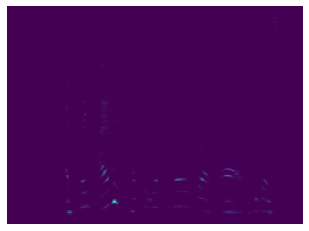

In [28]:
# Original
T.plot_melspectrogram(melspectrogram, hp)

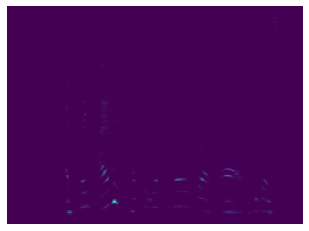

In [29]:
# reconstructed
melspectrogram_rec_from_db = T.db_to_amplitude(melspectrogram_db, hp)
T.plot_melspectrogram(melspectrogram_rec_from_db, hp)

In [30]:
# difference between spectrograms
print(torch.sum(torch.abs(melspectrogram_rec_from_db-melspectrogram)))
print(torch.sum(torch.abs(melspectrogram_rec_from_db-melspectrogram))/torch.sum(torch.abs(melspectrogram)))

tensor(0.0211, device='cuda:0')
tensor(1.8688e-07, device='cuda:0')


In [31]:
print("Melspectrogram:             ", melspectrogram.shape, " Shape: [B, N_MELS, FREQ]")
print("Melspectrogram_db:          ", melspectrogram_db.shape, " Shape: [B, N_MELS, FREQ]")
print("Melspectrogram_rec_from_db: ", melspectrogram_rec_from_db.shape, " Shape: [B, N_MELS, FREQ]")

Melspectrogram:              torch.Size([1, 256, 348])  Shape: [B, N_MELS, FREQ]
Melspectrogram_db:           torch.Size([1, 256, 348])  Shape: [B, N_MELS, FREQ]
Melspectrogram_rec_from_db:  torch.Size([1, 256, 348])  Shape: [B, N_MELS, FREQ]


## Extra: impact of applying amplitude_to_db conversion before MelScale

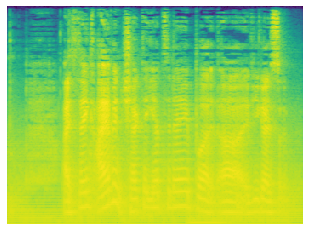

In [32]:
import torchaudio
# waveform -> linear spectrogram -> amplitude to db -> mel spectrogram
spectrogram = T.wave_to_spectrogram(waveform1, hp)
spectrogram_db = T.amplitude_to_db(spectrogram, hp)
melspectrogram = T.spectrogram_to_melspectrogram(spectrogram_db, hp)
T.plot_melspectrogram(melspectrogram, hp)

## Complete Pipeline:
Wave - Spectrogram - MelSpectrogram - MelSpectrogram dB - MelSpectrogram - Wave 

In [33]:
wave_orig = waveform1
spectrogram_orig = T.wave_to_spectrogram(wave_orig, hp)
melspectrogram_orig = T.spectrogram_to_melspectrogram(spectrogram_orig, hp)
melspectrogram_db_orig = T.amplitude_to_db(melspectrogram_orig, hp)
melspectrogram_rec = T.db_to_amplitude(melspectrogram_db_orig, hp)
spectrogram_rec = T.melspectrogram_to_spectrogram(melspectrogram_rec, hp, n_iter=10000)
wave_rec = T.spectrogram_to_wave(spectrogram_rec, hp, n_iter=1000)

In [34]:
# difference between waves
print(wave_orig.shape, wave_rec.shape)
print(torch.sum(torch.abs(wave_rec.flatten()-wave_orig.flatten()[:wave_rec.size(2)])))
print(torch.sum(torch.abs(wave_rec.flatten()-wave_orig.flatten()[:wave_rec.size(2)]))/torch.sum(torch.abs(wave_orig.flatten()[:wave_rec.size(2)])))

torch.Size([1, 1, 89061]) torch.Size([1, 1, 88832])
tensor(1921.4963, device='cuda:0')
tensor(1.3608, device='cuda:0')


Waveform 0, shape: torch.Size([1, 89061])
Waveform 0, Sample rate: 22050


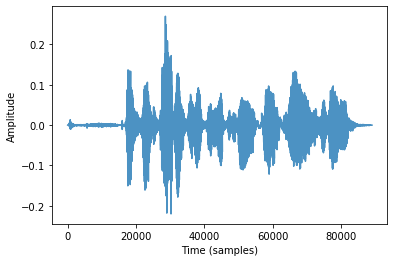

In [35]:
# Original
T.plot_wave(waveform1, hp)

Waveform 0, shape: torch.Size([1, 88832])
Waveform 0, Sample rate: 22050


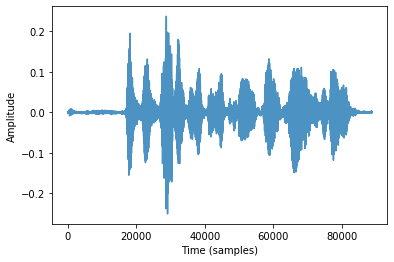

In [36]:
T.plot_wave(wave_rec, hp)

In [37]:
print("Original:")
IPython.display.Audio(data=wave_orig.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Original:


In [38]:
print("Reconstructed:")
IPython.display.Audio(data=wave_rec.flatten().detach().to('cpu').numpy(), rate=hp.audio.sample_rate)

Reconstructed:
